In [17]:
import pandas as pd
import numpy as np
import seaborn as sns 
import pathlib as Path
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
import matplotlib.pyplot as plt

import pandas as pd
import os
import pathlib as Path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
import itertools

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px

seed_value = 510444756

import warnings
warnings.filterwarnings('ignore')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324271 entries, 0 to 324270
Data columns (total 40 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   name                                         324271 non-null  object        
 1   kWh                                          324271 non-null  float64       
 2   Temperature                                  324271 non-null  float64       
 3   Alpha                                        324271 non-null  float64       
 4   Aerosol Optical Depth                        324271 non-null  float64       
 5   Asymmetry                                    324271 non-null  float64       
 6   Clearsky DHI                                 324271 non-null  int64         
 7   Clearsky DNI                                 324271 non-null  int64         
 8   Clearsky GHI                                 324271 non-null  in

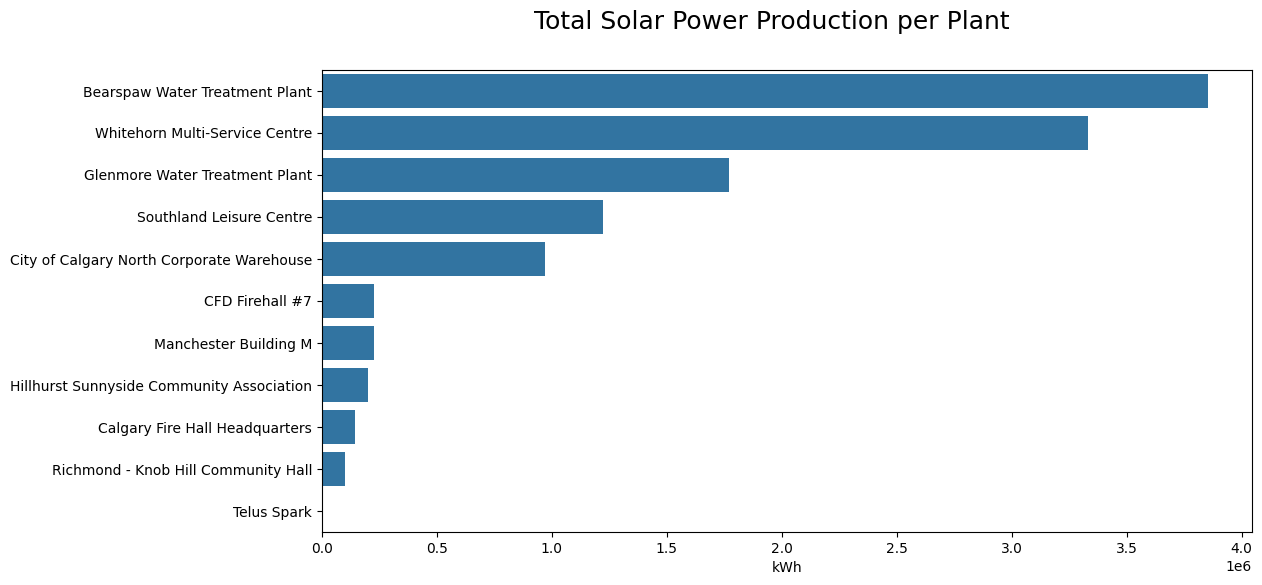

In [18]:
DB_FILEPATH = "..\Data\DBcleaned.csv"
OUTPUT = 'kWh'

energy_production = pd.read_csv(DB_FILEPATH)

energy_production["date"] = pd.to_datetime(energy_production["datetime"], format='%d/%m/%Y %H:%M')
energy_production.drop(columns = ["datetime"], inplace = True)
energy_production.info()

totoal_plant_production = energy_production.groupby('name')[['kWh']].sum().sort_values('kWh', ascending=False).reset_index()

fig, ax = plt.subplots(figsize = (12,6))    
sns.barplot(totoal_plant_production, x='kWh', y='name')
ax.set(ylabel=None)

fig.suptitle('Total Solar Power Production per Plant', fontsize=18)
fig.show()

In [19]:
frequency = ['h', 'd', 'W', 'M'][2]
plant_name = "Whitehorn Multi-Service Centre"
forecast_horizon = 52
year_start = 2017
fh = list(range(1,forecast_horizon + 1))

regression_models = {
    'Lin_Reg': LinearRegression,
    'LGBM':LGBMRegressor
}

statistical_models = {
    'AutoARIMA': AutoARIMA,
    'AutoETS': AutoETS
}

## Evaluation
metrics = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'r2': r2_score
}

In [20]:
plant_data = (energy_production
              .loc[energy_production.name == plant_name, ['date', 'kWh']]
              .set_index('date')
              .resample(frequency).sum()
              .resample(frequency).asfreq().fillna(0)      
        )

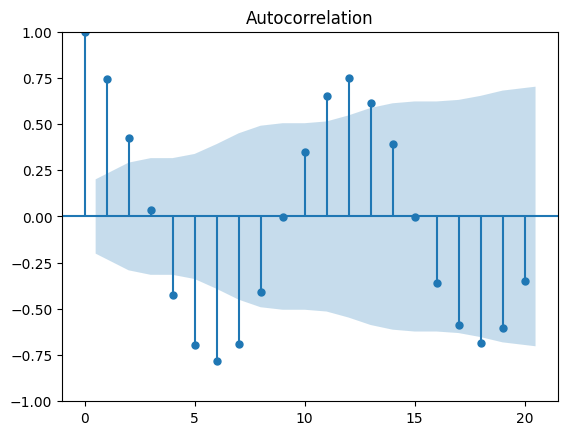

In [21]:
plot_acf(plant_data.resample("ME").sum())
plt.show()

In [22]:
series_data = plant_data.loc[plant_data.index.year >= year_start].kWh
    
train, test = temporal_train_test_split(series_data, test_size=forecast_horizon)

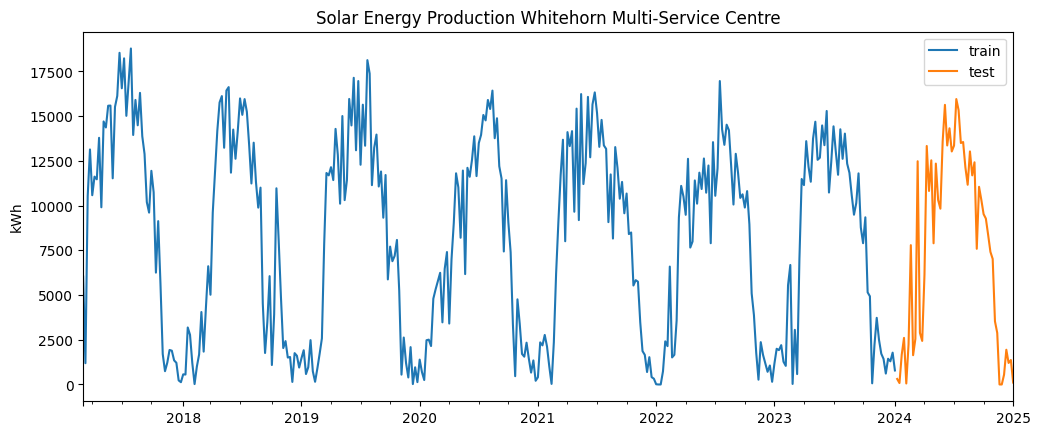

In [23]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.title('Solar Energy Production ' + plant_name)
ax.set(ylabel="kWh")
ax.set_xlabel('')
plt.legend();

In [24]:
train_opt, val_opt = temporal_train_test_split(train, test_size=forecast_horizon)

def get_evaluation_results(predictions):
    models = [model_name for model_name in  hyperparameter_result.columns if model_name != 'y_true']

    metrics_frame = []
    for metric_name in metrics.keys():
        for model in models:
            metrics_frame.append(pd.DataFrame({
                'Metric': [metric_name],
                'Model': [model],
                'Score': [metrics[metric_name](hyperparameter_result['y_true'], hyperparameter_result[model])]
            }))
            
    metrics_frame = pd.concat(metrics_frame)
    
    return metrics_frame

In [25]:
### Modelling Parameters
model_name = 'Lin_Reg'
reg_model = regression_models[model_name]()

## Hyperparameter Ranges
lookback_windows = [12,24,52,105]
forecasting_approaches = ['direct', 'recursive', 'dirrec']

hyperparams_grid = [lookback_windows] + [forecasting_approaches]
hyperparams_grid = list(itertools.product(*hyperparams_grid))

hyperparameter_result = val_opt.to_frame().rename(columns={'kWh':'y_true'}).copy()

print(f"Evaluating {len(hyperparams_grid)} hyperparameter combinations")

for params in hyperparams_grid:
    lookback_window, approach = params
    
    forecaster = make_reduction(reg_model, window_length=lookback_window, strategy=approach)
    fit_kwargs = {} if approach == 'recursive' else {'fh':fh}
        
    # Fit and predict
    forecaster.fit(train_opt, **fit_kwargs)        
    prediction = forecaster.predict(fh=fh)
    
    hyperparameter_result[approach + "_" + model_name + "_Window_" + str(lookback_window)] = prediction    
    
hyperparameter_metrics =  get_evaluation_results(hyperparameter_result)
hyperparameter_metrics.sort_values('Score').groupby('Metric').head(1)

Evaluating 12 hyperparameter combinations


,Metric,Model,Score
0,r2,recursive_Lin_Reg_Window_12,5.084707e-01
0,MAE,dirrec_Lin_Reg_Window_12,1.487384e+03
0,MSE,direct_Lin_Reg_Window_12,4.119608e+06


In [26]:
### Modelling Parameters
model_name = 'LGBM'
reg_model = regression_models[model_name](seed=seed_value)
lookback_windows = [12,24,52]
forecasting_approaches = ['direct', 'recursive', 'dirrec']

hyperparams_grid = [lookback_windows] + [forecasting_approaches]
hyperparams_grid = list(itertools.product(*hyperparams_grid))

hyperparameter_result = val_opt.to_frame().rename(columns={'kWh':'y_true'}).copy()

print(f"{len(hyperparams_grid)} hyperparameter combinations")

for params in hyperparams_grid:
    lookback_window, approach = params
    
    forecaster = make_reduction(reg_model, window_length=lookback_window, strategy=approach)
    fit_kwargs = {} if approach == 'recursive' else {'fh':fh}
        
    # Fit and predict
    forecaster.fit(train_opt, **fit_kwargs)        
    prediction = forecaster.predict(fh=fh)
    
    hyperparameter_result[approach + "_" + model_name + "_Window_" + str(lookback_window)] = prediction    
    
hyperparameter_metrics =  get_evaluation_results(hyperparameter_result)
hyperparameter_metrics.sort_values('Score').groupby('Metric').head(1)

9 hyperparameter combinations
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 984
[LightGBM] [Info] Number of data points in the train set: 243, number of used features: 12
[LightGBM] [Info] Start training from score 8158.105579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

,Metric,Model,Score
0,r2,recursive_LGBM_Window_12,-6.458021e-01
0,MAE,direct_LGBM_Window_52,1.467261e+03
0,MSE,direct_LGBM_Window_52,3.812914e+06


In [27]:
# Use to save all Model Prediction
evaluation_frame = test.to_frame().rename(columns={'kWh':'y_true'}).copy()

# 1. Linear Regression
window_size = 24
approach = 'dirrec'
model_name = 'Lin_Reg'
forecaster = make_reduction(regression_models[model_name](), window_length=window_size, strategy=approach)
fit_kwargs = {} if approach == 'recursive' else {'fh':fh}
print(f"Fitting {model_name}")
forecaster.fit(train, **fit_kwargs)
prediction = forecaster.predict(fh=fh)

evaluation_frame[model_name] = prediction


# 2. Light GBM
window_size = 52
approach = 'recursive'
model_name = 'LGBM'
forecaster = make_reduction(regression_models[model_name](seed=seed_value), window_length=window_size, strategy=approach)
fit_kwargs = {} if approach == 'recursive' else {'fh':fh}
print(f"Fitting {model_name}")
forecaster.fit(train, **fit_kwargs)
prediction = forecaster.predict(fh=fh)

evaluation_frame[model_name] = prediction

Fitting Lin_Reg
Fitting LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5304
[LightGBM] [Info] Number of data points in the train set: 306, number of used features: 52
[LightGBM] [Info] Start training from score 8038.924828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [28]:
for model_name in statistical_models.keys():
    forecaster = statistical_models[model_name]()
    print(f"Fitting {model_name}")
    forecaster.fit(train)
    prediction = forecaster.predict(fh=fh)
    
    evaluation_frame[model_name] = prediction

Fitting AutoARIMA


c:\Users\Luke\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Luke\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Luke\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Luke\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Luke\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6

Fitting AutoETS


c:\Users\Luke\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Luke\.pyenv\pyenv-win\versions\3.12.10\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [29]:
plot_df = evaluation_frame.reset_index().melt(id_vars='date').rename(columns={'value':'kWh'})
plot_df = pd.concat([train.reset_index().assign(variable="y_true"), plot_df])

px.line(plot_df, x='date', y='kWh', color='variable', title="Model Predictions vs. True Value")

In [30]:
models = [model_name for model_name in  evaluation_frame.columns if model_name != 'y_true']

metrics_frame = []
for metric_name in metrics.keys():
    for model in models:
        
        metrics_frame.append(pd.DataFrame({
            'Metric': [metric_name],
            'Model': [model],
            'Score': [metrics[metric_name](evaluation_frame['y_true'], evaluation_frame[model])]
        }))
                      
metrics_frame = pd.concat(metrics_frame)

metric = 'MAE'
px.bar(metrics_frame.loc[metrics_frame.Metric == metric], x='Model', color='Model', y='Score')



In [31]:
metric = 'MSE'
px.bar(metrics_frame.loc[metrics_frame.Metric == metric], x='Model', color='Model', y='Score')

In [32]:
metric = 'r2'
px.bar(metrics_frame.loc[metrics_frame.Metric == metric], x='Model', color='Model', y='Score')